# Keras Tutorial : Facial Expression Recognition Challenge 
### Using FER2013 faces dataset
By Yash

# About this notebook

This notebook consists of a detailed tutorial in keras for a kaggle problem called [Facial Expression Recognition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge). A dataset of images of people's faces is given. As the name suggests, we have to classify the facial expression into 7 categories : Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral. 

In this section, let's have an overall look on rest of the sections in this notebook. 

1. This tutorial starts with a brief introduction to Convolution neural networks and it's application on image datasets. 

2. Then the following section talks about the environment setup required like installing libraries and importing the datasets.

3. Once we have the playground ready, it's time to play ;). Before we dwell into building the AI model, understanding the data is very important. Unlike conventional programming, building a model in this field depends on the structure and distribution of data. So, in this section we do some Exploratory data analysis and get a feel on the structure of given data.

4. Most of the times, given datasets have few flaws. In this case, we will see that the number of datasets for each class have high variation. And a solution will be proposed for the same in Data-preprocessing.

5. Once we have the processed data, it time to build the architecture. This section first talks about the observations I personally drew by experimenting with various hyper-parameters like filter size, no. of filters, no. of layers, learning rates, etc. Then the model is trained and a bried assessment is given over a set of epochs.

6. Once the model is trained, we test it on the test data set and perform a final assessment.

7. The appendix consists of future works and references and other misclaneous things.


# 1.  Introduction to convolution neural networks and it's application on image datasets.

In 1960s, attempts were made to mimic the brain with an expectation of achieving artificial intelligence. And that is how the neural network architecture or neural netwroks were proposed which was insipred from biological strucuture of the brain.

When initial neural networks were introduced and applied for solving visual tasks, all pixels were taken individually as an input and then process them through various layers of this neural network. This is called a fully-connected network. This infact worked well in few cases like the MNIST dataset (consists of images of handwritten digits). 

<p align="center">
  <img src="https://github.com/suraj2596/EIP/blob/master/FINAL/1.gif?raw=true"/>
</p>


But when more complex features have to be extracted like curves, shapes, patterns, etc... the fully connected networks tend to fail. This is due to the fact that they do not consider the spatial corelations among various pixels. To overcome this, various other methods were introduced but convolution neural networks was accepted the most and still beinf used.

Convolution neural networks (CNNs), as the name suggests, uses the methodology of convolution*. In convolution, we take 2 inputs or entities which have spatial occupancy, Eg; array or matrix and not a single variable. When the first entity is slidedover the second enitity and sum of multiplications is taken, each step will produce a value. This is the result of convolution. Same methodology can be extended for 2 dimensions. And this is used in CNNs.

<p align="center">
  <img src="https://github.com/suraj2596/EIP/blob/master/FINAL/2.gif?raw=true"/>
</p>


The second entity in case of CNNs is called a filer or kernel. The resultant of the convolution is called feature map. So, when an input to a particular layer is used to convolve with one kernel or filter, a feature map is produced. number of feature maps is equal to number of filters.
If this structure is cascaded, it called a deep convolution neural networks.


*Strictly speaking, it should be called co-relation, not convolution. When 2 entities are convolved, the 2nd entity is supposed to be mirrored and taken into calculation.

# 2. Environment Setup


## Setting up Google Colab
**NOTE : This tutorial was made to be used on Goolge colab. If you are implementing in a local system, you can skip this section.**

In [0]:
#Linking drive to colab to store datasets
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library. Though the link asks you to verify twice, you don't have to!
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
# Create a directory
!mkdir -p drive

#mount Google Drive using the created directory.
!google-drive-ocamlfuse drive
!ls drive

## Required environment setup and downloading datasets
**NOTE : Irrespective of local or Colab instances, this section must be executed**

In [6]:
#This step is for the model to auto save the weights to your drive. 
#So for the next time, you can resume where you left off. 
#Let's call this the sync folder. Change the name of the folder based on your environment
path_to_save = 'drive/EIP/Facial_Expression_Recognition/'

#Echo the contents of the sync folder
print ('Files in the sync folder:')
!ls $path_to_save

#Assuming the compressed dataset is in the sync folder... 
#Colab users, once downloaded, upload it to your sync folder and then execute this.
#It is a 92MB file.
!tar -xvf $path_to_save/fer2013.tar.gz

Files in the sync folder:
datalab  fer2013  fer2013.tar.gz  iter_2  iter_3  iter_4  iter_5  iter_6
fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [13]:
# Run this only when starting a new session. Syncing files in drive to pwd on colab instance.
!cp -a $path_to_save/ .
!ls

datalab  drive	fer2013  *.hdf5


## Import required libraries

In [8]:
#Installing keras
!pip install -q keras
!pip install -q pathlib

#Framework related libraries
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers import MaxPooling2D, BatchNormalization, SeparableConv2D
from keras.optimizers import Adam

##---------------------------------------------##

#For loading models
from pathlib import Path
from keras.models import load_model

##---------------------------------------------##

##Data preprocessing

#for class balance
from sklearn.utils import class_weight

#For data augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

##---------------------------------------------##

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
#tf.python.control_flow_ops = tf
from keras import backend as k

##---------------------------------------------##

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

##---------------------------------------------##

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

##---------------------------------------------##

#Data handling libraries
import numpy as np
import pandas as spd

##---------------------------------------------##

#Image handling libraries
import matplotlib
import matplotlib.pyplot as plt

##---------------------------------------------##

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 3. Exploratory Data Analysis



## Import and sample data

In [0]:
#Given data set is in csv format after unzipping.

file = 'fer2013/fer2013.csv'
df = spd.read_csv(file)

In [0]:
#Assign separate data frames to training, cross-validation and test data

#Training set
tr_set = df.loc[df['Usage'] == 'Training']
tr = tr_set.loc[:,'pixels']
tr_labels = tr_set.loc[:,'emotion']

#Cross-validation set
cv_set = df.loc[df['Usage'] == 'PublicTest']
cv = cv_set.loc[:,'pixels']
cv_labels = cv_set.loc[:,'emotion']

#Test set
te_set = df.loc[df['Usage'] == 'PrivateTest']
te = te_set.loc[:,'pixels']
te_labels = te_set.loc[:,'emotion']

Lets randomly sample 5 images of each emotion from training dtaset

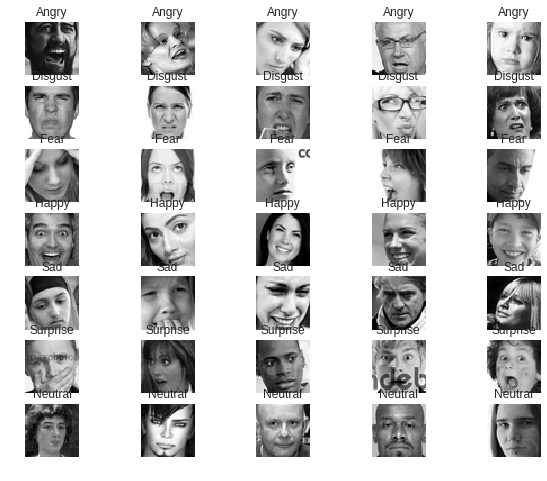

In [11]:
tr_set_emotions_label = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

#size of each class will be stored in this array
t=np.zeros(np.size(tr_set_emotions_label)) 

#No. of images to sample from each class
sample_size=5

#Display those images
for k,e in enumerate(tr_set_emotions_label):
  this_emotion_set = df.loc[(df['Usage'] == 'Training') & (df['emotion'] == k)]
  t[k] = this_emotion_set.size
  x=this_emotion_set.sample(n=sample_size).loc[:,'pixels']
  for i,j in enumerate(x):
    plt.subplot(t.size, sample_size,(sample_size*k)+i+1)
    y = j.split(' ')
    x = np.array(y).reshape(48,48)
    plt.axis('off')
    plt.grid('off')
    plt.imshow(x.astype('uint8'))
    plt.title(e)

## Inferences


1.   The data provided is flattened/unrolled. To display them, we have to roll or reshape the vectors.
2.   This dataset consists of faces of various expressions of all kinds of age, race and sex. That means the data is well generalized. 
3.   Faces in the images seemed to be centered. So, face detection and extraction can be skipped.
4.   Images are in grey scale. That means fewer parameters.
5.  Given the classes 'Surprise' and 'Happy', there might be high chance of misclassification. This is due to their high spatial corelation.

Let's explore data distribution among various classes

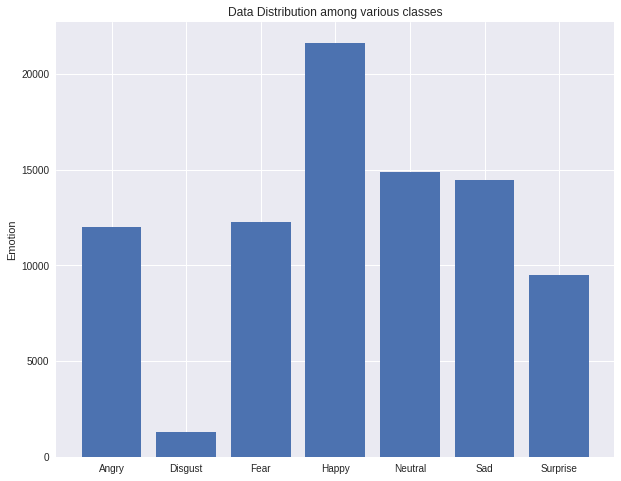

In [12]:
#Plotting no. of training examples vs their class
plt.bar(tr_set_emotions_label, t)
plt.ylabel('No. of training examples')
plt.ylabel('Emotion')
plt.title('Data Distribution among various classes')

plt.show()  

* It can be observed that the class 'Disgust' has very less number of training data. 

* And there is a high possibility of the model to predict 'Happy' if the training data isn't normalized.

* This problem can be solved in various ways:

  1.** Assigning weightage** for each class using Keras 'class_weight'. This is preferred.
  
  2.** Data augmentation** - Since the variation among the no. of training examples accross the classes is very high, using augmentation to just few classes to balance the data might not be a good idea. If we do that, there will be a rich variation in 'Happy' class and less variations in 'disgust' class and training over this data would be redundant. But applying Augmentation on all of the classes is a good idea.
  
  3.** Removing data** from other classes. Loss of data is not usually encouraged. 

  4.** Using GANs** : New training data can be created from the respective class's distribution. This is an option too.


**NOTE : The labels on the x-axis are not in order of the labels 0-7**

# 4. Data Pre-processing

## Rolling the data
The given data is in form of csv file. Here, we convert them into an array of images and sort them into train, validation and test data.

In [13]:
#train data
tr_img = []
tr_l = np.zeros((np.size(tr),np.size(t)))
for p,i in enumerate(tr):
    y = i.split(' ')
    y = np.array(y).reshape(48,48,1)
    tr_img.append(y)
    tr_l[p,tr_labels[p]]=1
tr_img = np.array(tr_img)
print(tr_img.shape)

(28709, 48, 48, 1)


In [14]:
#cv data
cv_img = []
cv_l = np.zeros((np.size(cv),np.size(t)))
for p,i in enumerate(cv):
    y = i.split(' ')
    y = np.array(y).reshape(48,48,1)
    cv_img.append(y)
    cv_l[p,cv_labels[np.size(tr)+p]] = 1
cv_img = np.array(cv_img)
print(cv_img.shape)

(3589, 48, 48, 1)


In [15]:
#test data
te_img = []
te_l = np.zeros((np.size(te),np.size(t)))
for p,i in enumerate(te):
    y = i.split(' ')
    y = np.array(y).reshape(48,48,1)
    te_img.append(y)
    te_l[p,te_labels[np.size(tr) + np.size(cv) + p]]=1
te_img = np.array(te_img)
print(te_img.shape)

(3589, 48, 48, 1)


## Assigning weights to classes

In [16]:
#Finding the weightage to be given to each class
class_weights_array = np.max(t)//t

class_weight = dict(zip(np.arange(np.size(t)), class_weights_array))

print(class_weight)

{0: 1.0, 1: 16.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 1.0}


## Callbacks

In [0]:
# checkpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath= "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

earlyStopping = EarlyStopping(monitor='val_acc', min_delta=0.005, patience=8, verbose=0, mode='max')

callbacks_list = [checkpoint,earlyStopping]


## Data Augmentation

In [18]:
print('Using real-time data augmentation.')

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( 
    rotation_range=15, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True) 

datagen.fit(tr_img)
data_aug_x = datagen.flow(tr_img, tr_l, batch_size=64)

Using real-time data augmentation.


# 5. Acrhitecture

## Model

Few modifications are done to the network apart from the one specified in [zplure's](https://raw.githubusercontent.com/zlpure/Facial-Expression-Recognition/) repo so that it uses less parameters without compromising performance. The changes are:

* **Convolutions** : 
  *  The latest trend is NOT to use fully connected layers and use convolution layers as much as possible. This way, the parameters used will be less and computation will be faster. I have eliminated the 2 **FC1024** fully connected layers at the bottom. 
  
  * Seperable convolutions are used here. Eg : instead of 5 x 5, a pair of 5 x 1 and 1 x 5 are used. This way, the number of parameters drastically decrease. 

* **Filters** : Number of filters greatly affect no. of parameters. There must be good enough filters. Too many or too less affectes the accuracies. After few trail and errors, an optimal combination has been found.

* **Dropout** : As the model is designed for performing on few parameters, it's better to use a small dropout. Here, a dropout of 0.1 is being used as opposed to 0.45 in the repo.

* **Optimizer** : Adam optimizer is chosen for this problem. Initially, the default learning rate has been used. After 100th epoch, cyclic learning style has been implemented.

* **Mini-batch size** : A multiple of 32 is preferred. Becasue GPU's allocate in blocks of 32. Based on the batch size, a block size near to the multiple of 32 is allocated. o, it's better to use a bacth size in multiples of 32s to use the compute power effectively. Used a batch size of 64 in this tutorial. 

<p align="center">
  <img src="https://github.com/suraj2596/EIP/blob/master/FINAL/architecture.png?raw=true" width="350px" height="600px"/>
</p>

**OBSERVATIONS DRAWN FROM HYPERPARAMETER TUNING (MADE OVER 2000 EPOCHS)**
* Using kernel size 3 turned out to be unproductive. The accuracy of the model did not increase ata ll from the beginning. This was observed for 20 epochs and then terminated.

* Kernel size of 5 is used. This means few layers at the end have to be removed which decreased the parameters to 53k from 1M. Turns out 1M parameters was too much if only 1 dense/FC layer at the end is used.

* There was a quick rise in accuracy in early epochs but saturated after 50%. Though running the epochs continously thereafter shows increase in accuracy, the rise is very slow. So, I have used cyclic learning rates.

* Training the initial epochs on smaller images and furthering the training on actual images didn't have any affect on the smoothness of training. It's strange.


In [19]:
model = Sequential()

f =48
model.add(SeparableConv2D(f,(5,1),activation='relu', input_shape=(48,48,1)))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

##

f=96
model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#model.add(Dropout(0.1))

##

f=198
model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 44, 48, 48)        101       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 44, 44, 48)        2592      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 48)        192       
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 40, 44, 48)        2592      
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 40, 40, 48)        2592      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 39, 39, 48)        0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 35, 39, 96)        4944      
__________

## Epochs 1-175

While running a model, how do you asses the model's performance rather than waiting till the last epoch? Is there a way to see how the model is performing as it is being trainied? The answer is yes! And this section covers few basic techniques to keep in mind to assess the model's performance.


The performance of a model should be in the same level on new data as well as training data. Then we say the model has generalized well over the dataset. If it didn't generalize well, it'll lead to various problems.In one line, *monitoring the change of training accuracy and validation accuracy tells a lot about the model's training behaviour*

The following points need to be monitored while running a model. 

---

** > The difference between the training accuracy and validation accuracy starts increasing : *Overfitting* **  

  * **Definition** : Overfitting means the model is trying to remember the training data to produce high training accuracy or less training error. When this happens, the model will perform poor on data which it hadn't seen earlier.
  * **Reasons for a model to overfit and it's fixes** :
    * **No. of Parameters** : If the nmber of parameters are more than necessary, model becomes very flexible and becomes capable of remembering the data. It's a good practice to start with parameters around 1 million and try running it for few epochs. Based on the performance, increase or decrease the parameters.
    * **Regularization** : If you realise the model is if the model is overfitting after many epochs, you can add/increase dropout in the model rather than changing the no. of parameters itself. This way, dropout regularizes the models by trying to make it simpler.
    * **Using Data Augmentation** : When data is augmented, ie, new data is created by minute perturbations, model becomes more robust to changes and generalizes well. This is usually if available data is less or the data has high spatial variations.
 

** > Both training and validation accuracies are less : *Underfitting* **
  * **Definition** : Undefitting means the model is unable to learn to fit the data. As a result, it'll perform poor on any new data too.
  * **Reasons for a model to underfit and it's fixes** : It is just opposite to overfitting. Refer the above sections for the reasons and it's fixes
  
<br /><br />

<p align="center">
  <img src="https://github.com/suraj2596/EIP/blob/master/FINAL/3.png?raw=true" width="600px" ><br />
  <em>An intuition for overfitting v/s underfitting. One must note that a Neural network deals with much more high dimensional data as opposed to 2D data shown in the above figures</em><br /><br />
</p>

---
**> If training or validation accuracy changes very slowly : Low value of learning rate**
  *  **Reasons and it's fixes**
    * When the learning rate is less, the accuracies change very slowly over epochs. There is nothing wrong in doing this except it takes a lot of time for the model to converge.
    * Usually, the default learning rates for optimizers in Keras work fine in most of the cases. In case the learning rate has to be changed, specify it before compiling the model.    


**> If training or validation accuracy fluctuate a lot : High value of learning rate**
  *  **Reasons and it's fixes**
    * When the learning rate is high, the accuracies start fluctuating at some point. This happens because it takes a bigger step when the model is near convergence. Due to this, the accuracies fluctuate.
    * This would usually be the case after the model has ran multiple epochs. So, learning rates are reduced as we proceed down the no. of epochs. There are many ways the learning rates can be changed. They are called optimizers. In our case, we use Adam optimizer.

<p align="center">
  <img src="https://github.com/suraj2596/EIP/blob/master/FINAL/4..gif?raw=true" width="400px" >
  <img src="https://github.com/suraj2596/EIP/blob/master/FINAL/5..gif?raw=true" width="400px" ><br />
  <em>Observe the red dots in the figures below. In case of left figure, it takes many iterations or epochs to converge to the minima. Inthe right figure, observe the fluctuation</em><br /><br />
  
</p>
    
If you want to know more about optimizers, [here](http://ruder.io/optimizing-gradient-descent/) is a good read.

### Epoch 1-10
**ASSESSMENT : Training and validation accuracies are closeby. Nothing to worry**

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epoch = 0
model.fit_generator(data_aug_x, 
                    epochs=10,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 1/10
449/449 [==============================] - 94s 209ms/step - loss: 3.1383 - acc: 0.1339 - val_loss: 1.9261 - val_acc: 0.1688

Epoch 00001: val_acc improved from -inf to 0.16885, saving model to weights-improvement-01-0.17.hdf5
Epoch 2/10
177/449 [==========>...................] - ETA: 51s - loss: 3.0982 - acc: 0.1723449/449 [==============================] - 91s 202ms/step - loss: 3.0474 - acc: 0.1721 - val_loss: 2.5576 - val_acc: 0.1162

Epoch 00002: val_acc did not improve from 0.16885
Epoch 3/10
292/449 [==================>...........] - ETA: 29s - loss: 2.9708 - acc: 0.2004449/449 [==============================] - 91s 202ms/step - loss: 2.9319 - acc: 0.2150 - val_loss: 1.7657 - val_acc: 0.2884

Epoch 00003: val_acc improved from 0.16885 to 0.28838, saving model to weights-improvement-03-0.29.hdf5
Epoch 4/10
271/449 [=================>............] - ETA: 33s - loss: 2.8788 - acc: 0.2515449/449 [==============================] - 91s 202ms/step - loss: 2.8471 - acc: 0.2642

### Epoch 11-30
**ASSESSMENT : Only validation accuracy is fluctuating near the end. But variation training accuracy seems to be smooth. This is due to the small size of validation set and the active learning of the model**

In [0]:
model.load_weights('weights-improvement-10-0.39.hdf5')

epoch=10
model.fit_generator(data_aug_x, 
                    epochs=30,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 11/30
449/449 [==============================] - 91s 202ms/step - loss: 2.4302 - acc: 0.3986 - val_loss: 1.6574 - val_acc: 0.3722

Epoch 00011: val_acc did not improve from 0.39008
Epoch 12/30
208/449 [============>.................] - ETA: 45s - loss: 2.3938 - acc: 0.4016449/449 [==============================] - 90s 201ms/step - loss: 2.3894 - acc: 0.4040 - val_loss: 1.5094 - val_acc: 0.4230

Epoch 00012: val_acc improved from 0.39008 to 0.42296, saving model to weights-improvement-12-0.42.hdf5
Epoch 13/30
248/449 [===============>..............] - ETA: 37s - loss: 2.3837 - acc: 0.4131449/449 [==============================] - 91s 202ms/step - loss: 2.3463 - acc: 0.4176 - val_loss: 1.4536 - val_acc: 0.4450

Epoch 00013: val_acc improved from 0.42296 to 0.44497, saving model to weights-improvement-13-0.44.hdf5
Epoch 14/30
259/449 [================>.............] - ETA: 35s - loss: 2.3075 - acc: 0.4292449/449 [==============================] - 91s 202ms/step - loss: 2.3148 - acc:

### Epoch 31-50
**ASSESSMENT : Nothing to worry here too**

In [0]:
model.load_weights('weights-improvement-29-0.51.hdf5')

epoch = 30
model.fit_generator(data_aug_x, 
                    epochs=50,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 31/50
449/449 [==============================] - 91s 203ms/step - loss: 1.9873 - acc: 0.4960 - val_loss: 1.4338 - val_acc: 0.4765

Epoch 00031: val_acc did not improve from 0.50627
Epoch 32/50
207/449 [============>.................] - ETA: 45s - loss: 1.9393 - acc: 0.5103449/449 [==============================] - 91s 203ms/step - loss: 1.9869 - acc: 0.4995 - val_loss: 1.3047 - val_acc: 0.5110

Epoch 00032: val_acc improved from 0.50627 to 0.51101, saving model to weights-improvement-32-0.51.hdf5
Epoch 33/50
247/449 [===============>..............] - ETA: 38s - loss: 1.9379 - acc: 0.5045449/449 [==============================] - 91s 203ms/step - loss: 1.9601 - acc: 0.5030 - val_loss: 1.3373 - val_acc: 0.5157

Epoch 00033: val_acc improved from 0.51101 to 0.51574, saving model to weights-improvement-33-0.52.hdf5
Epoch 34/50
258/449 [================>.............] - ETA: 35s - loss: 1.9365 - acc: 0.5100449/449 [==============================] - 91s 203ms/step - loss: 1.9556 - acc:

### Epoch 51-70
**ASSESSMENT : Very slight overfitting started to appear here. Let's wait few more epochs to address this problem. Thumb rule, take any action to rectify overfitting if the difference gradually increases and not due to fluctuations. Also, the difference must be more than 10%. This isn't a standard value. Just a measure I gained over experience.**

In [0]:
model.load_weights('weights-improvement-48-0.54.hdf5')

epoch = 50
model.fit_generator(data_aug_x, 
                    epochs=70,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 51/70
449/449 [==============================] - 91s 202ms/step - loss: 1.7646 - acc: 0.5402 - val_loss: 1.4448 - val_acc: 0.4798

Epoch 00051: val_acc did not improve from 0.54026
Epoch 52/70
207/449 [============>.................] - ETA: 45s - loss: 1.7320 - acc: 0.5449449/449 [==============================] - 91s 203ms/step - loss: 1.7446 - acc: 0.5424 - val_loss: 1.2840 - val_acc: 0.5417

Epoch 00052: val_acc improved from 0.54026 to 0.54166, saving model to weights-improvement-52-0.54.hdf5
Epoch 53/70
249/449 [===============>..............] - ETA: 37s - loss: 1.7891 - acc: 0.5376449/449 [==============================] - 91s 203ms/step - loss: 1.7854 - acc: 0.5387 - val_loss: 1.3046 - val_acc: 0.5219

Epoch 00053: val_acc did not improve from 0.54166
Epoch 54/70
312/449 [===================>..........] - ETA: 25s - loss: 1.7379 - acc: 0.5462449/449 [==============================] - 91s 202ms/step - loss: 1.7468 - acc: 0.5444 - val_loss: 1.4170 - val_acc: 0.4876

Epoch 00

### Epochs 71-80
**ASSESSMENT : Good amount of learning has happened here. We are still good. Nothing to worry**

In [0]:
model.load_weights('weights-improvement-63-0.55.hdf5')

epoch = 70
model.fit_generator(data_aug_x, 
                    epochs=80,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 71/80
449/449 [==============================] - 94s 210ms/step - loss: 1.6484 - acc: 0.5652 - val_loss: 1.3410 - val_acc: 0.5116

Epoch 00071: val_acc improved from -inf to 0.51156, saving model to weights-improvement-71-0.51.hdf5
Epoch 72/80
174/449 [==========>...................] - ETA: 52s - loss: 1.5977 - acc: 0.5789449/449 [==============================] - 92s 204ms/step - loss: 1.6562 - acc: 0.5626 - val_loss: 1.2905 - val_acc: 0.5327

Epoch 00072: val_acc improved from 0.51156 to 0.53274, saving model to weights-improvement-72-0.53.hdf5
Epoch 73/80
239/449 [==============>...............] - ETA: 39s - loss: 1.6354 - acc: 0.5698449/449 [==============================] - 92s 204ms/step - loss: 1.6569 - acc: 0.5659 - val_loss: 1.2964 - val_acc: 0.5302

Epoch 00073: val_acc did not improve from 0.53274
Epoch 74/80
306/449 [===================>..........] - ETA: 27s - loss: 1.6177 - acc: 0.5738449/449 [==============================] - 92s 204ms/step - loss: 1.6221 - acc: 0.

### Epoch 81-100
**ASSESSMENT : The learning seems to be capped. Let's reduce the learning rate from the next set of epochs.**

In [0]:
model.load_weights('weights-improvement-80-0.56.hdf5')
epoch = 80
model.fit_generator(data_aug_x, 
                    epochs=100,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 81/100
449/449 [==============================] - 92s 205ms/step - loss: 1.5933 - acc: 0.5769 - val_loss: 1.2578 - val_acc: 0.5497

Epoch 00081: val_acc did not improve from 0.56478
Epoch 82/100
201/449 [============>.................] - ETA: 47s - loss: 1.5621 - acc: 0.5758449/449 [==============================] - 92s 205ms/step - loss: 1.5782 - acc: 0.5780 - val_loss: 1.4031 - val_acc: 0.5121

Epoch 00082: val_acc did not improve from 0.56478
Epoch 83/100
293/449 [==================>...........] - ETA: 29s - loss: 1.5692 - acc: 0.5794449/449 [==============================] - 92s 205ms/step - loss: 1.5936 - acc: 0.5755 - val_loss: 1.5082 - val_acc: 0.4617

Epoch 00083: val_acc did not improve from 0.56478
Epoch 84/100
320/449 [====================>.........] - ETA: 24s - loss: 1.5566 - acc: 0.5844449/449 [==============================] - 92s 205ms/step - loss: 1.5713 - acc: 0.5817 - val_loss: 1.2584 - val_acc: 0.5327

Epoch 00084: val_acc did not improve from 0.56478
Epoch 85

### Epochs 100-120
**ASSESSMENT : Changing learning rate proved to be effective.**

* Started using EarlyStopping callback from this point. The function of this callback monitors the change in specified parameter, ie, in this case:"val_acc", and stops the training process if there isn't any considerable amount of change. 
* This is specifically used when we reduce the learning rate as it slows down the learning and stopping the process early is better if there isn't much learning. Then we could use a different learning rate and proceed.

In [23]:
adam = Adam(lr=0.0005)

model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy'])

model.load_weights('weights-improvement-97-0.58.hdf5')
epoch = 100
model.fit_generator(data_aug_x, 
                    epochs=120,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 101/120
449/449 [==============================] - 90s 200ms/step - loss: 1.3120 - acc: 0.6370 - val_loss: 1.3437 - val_acc: 0.5327

Epoch 00101: val_acc improved from -inf to 0.53274, saving model to weights-improvement-101-0.53.hdf5
Epoch 102/120
170/449 [==========>...................] - ETA: 52s - loss: 1.2892 - acc: 0.6421449/449 [==============================] - 90s 201ms/step - loss: 1.2979 - acc: 0.6422 - val_loss: 1.2029 - val_acc: 0.5823

Epoch 00102: val_acc improved from 0.53274 to 0.58233, saving model to weights-improvement-102-0.58.hdf5
Epoch 103/120
238/449 [==============>...............] - ETA: 39s - loss: 1.2848 - acc: 0.6435449/449 [==============================] - 90s 201ms/step - loss: 1.2923 - acc: 0.6436 - val_loss: 1.1988 - val_acc: 0.5851

Epoch 00103: val_acc improved from 0.58233 to 0.58512, saving model to weights-improvement-103-0.59.hdf5
Epoch 104/120
255/449 [================>.............] - ETA: 36s - loss: 1.2814 - acc: 0.6447449/449 [========

From epoch 108, we can see that there is not much change in validation accuracy but there is constant increase in training accuracy. Also, there is an increasing gap between training and validation accuracies which indicates overfitting. To solve this issue, cyclic learning rates can be used. Let's try using a learning rate of 0.003 ie 3 times the starting learning rate of Adam optimizer. This way, if the model got stuck in some local minima, it would come out. Then using smaller learning rates, we can proceed to global minimas

### Epochs 118-125
**ASSESSMENT : It is natural to observe a huge change when the learning rate is increased suddenly. In other words, this is desirable and favourable change.**

In [26]:
adam = Adam(lr=0.003)

model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy'])


model.load_weights('weights-improvement-109-0.59.hdf5')
epoch = 117
model.fit_generator(data_aug_x, 
                    epochs=125,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 118/125
449/449 [==============================] - 91s 203ms/step - loss: 1.9241 - acc: 0.5234 - val_loss: 1.3469 - val_acc: 0.5093

Epoch 00118: val_acc did not improve from 0.59153
Epoch 119/125
202/449 [============>.................] - ETA: 45s - loss: 1.8695 - acc: 0.5310449/449 [==============================] - 88s 197ms/step - loss: 1.8885 - acc: 0.5247 - val_loss: 1.5443 - val_acc: 0.4433

Epoch 00119: val_acc did not improve from 0.59153
Epoch 120/125
296/449 [==================>...........] - ETA: 28s - loss: 1.8964 - acc: 0.5172449/449 [==============================] - 89s 197ms/step - loss: 1.9055 - acc: 0.5210 - val_loss: 1.3324 - val_acc: 0.5171

Epoch 00120: val_acc did not improve from 0.59153
Epoch 121/125
324/449 [====================>.........] - ETA: 23s - loss: 1.9215 - acc: 0.5168449/449 [==============================] - 88s 197ms/step - loss: 1.9450 - acc: 0.5122 - val_loss: 1.5995 - val_acc: 0.4581

Epoch 00121: val_acc did not improve from 0.59153
Epoc

### Epochs 125-150
**ASSESSMENT : Same fluctuations observed again. Seems like cyclic learning rates concept didn't have positive affect. I begin to suspect  the reason for the model to saturate in terms of accuracy is due to the less nubmer of parameters.**

In [27]:
adam = Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])


model.load_weights('weights-improvement-109-0.59.hdf5')
epoch = 140
model.fit_generator(data_aug_x, 
                    epochs=175,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 141/175
449/449 [==============================] - 91s 203ms/step - loss: 1.3374 - acc: 0.6388 - val_loss: 1.2483 - val_acc: 0.5631

Epoch 00141: val_acc did not improve from 0.59153
Epoch 142/175
202/449 [============>.................] - ETA: 46s - loss: 1.3224 - acc: 0.6369449/449 [==============================] - 89s 199ms/step - loss: 1.3430 - acc: 0.6323 - val_loss: 1.2502 - val_acc: 0.5740

Epoch 00142: val_acc did not improve from 0.59153
Epoch 143/175
296/449 [==================>...........] - ETA: 28s - loss: 1.3628 - acc: 0.6359449/449 [==============================] - 89s 199ms/step - loss: 1.3715 - acc: 0.6329 - val_loss: 1.2157 - val_acc: 0.5740

Epoch 00143: val_acc did not improve from 0.59153
Epoch 144/175
324/449 [====================>.........] - ETA: 23s - loss: 1.3608 - acc: 0.6327449/449 [==============================] - 89s 198ms/step - loss: 1.3852 - acc: 0.6272 - val_loss: 1.2707 - val_acc: 0.5628

Epoch 00144: val_acc did not improve from 0.59153
Epoc

### Epochs 155-166
**ASSESSMENT : Almost overfitting. Let's run for few more epochs to confirm overfitting**

In [28]:
adam = Adam(lr=0.0005)

model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy'])

model.load_weights('weights-improvement-109-0.59.hdf5')
epoch = 155
model.fit_generator(data_aug_x, 
                    epochs=170,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 156/170
449/449 [==============================] - 92s 205ms/step - loss: 1.2349 - acc: 0.6546 - val_loss: 1.2270 - val_acc: 0.5818

Epoch 00156: val_acc did not improve from 0.59153
Epoch 157/170
202/449 [============>.................] - ETA: 47s - loss: 1.2596 - acc: 0.6504449/449 [==============================] - 91s 203ms/step - loss: 1.2495 - acc: 0.6536 - val_loss: 1.2579 - val_acc: 0.5717

Epoch 00157: val_acc did not improve from 0.59153
Epoch 158/170
292/449 [==================>...........] - ETA: 29s - loss: 1.2484 - acc: 0.6558449/449 [==============================] - 91s 203ms/step - loss: 1.2323 - acc: 0.6573 - val_loss: 1.2289 - val_acc: 0.5913

Epoch 00158: val_acc did not improve from 0.59153
Epoch 159/170
320/449 [====================>.........] - ETA: 24s - loss: 1.2252 - acc: 0.6594449/449 [==============================] - 91s 203ms/step - loss: 1.2316 - acc: 0.6593 - val_loss: 1.2549 - val_acc: 0.5726

Epoch 00159: val_acc did not improve from 0.59153
Epoc

### Epochs 166-180
**ASSESSMENT : The model seems to have reached it's capacity. Going any further will overfit the model. One way to avoid this is to remove dropout entirely. But previous versions didn't show much change.**

In [32]:
adam = Adam(lr=0.0005)

model.compile(loss='categorical_crossentropy',
             optimizer=adam,
             metrics=['accuracy'])

model.load_weights('weights-improvement-162-0.60.hdf5')
epoch = 166
model.fit_generator(data_aug_x, 
                    epochs=180,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

!cp *.hdf5 $path_to_save

Epoch 167/180
449/449 [==============================] - 92s 204ms/step - loss: 1.2280 - acc: 0.6617 - val_loss: 1.2337 - val_acc: 0.5770

Epoch 00167: val_acc did not improve from 0.59571
Epoch 168/180
202/449 [============>.................] - ETA: 46s - loss: 1.1911 - acc: 0.6679449/449 [==============================] - 90s 200ms/step - loss: 1.2029 - acc: 0.6658 - val_loss: 1.2578 - val_acc: 0.5918

Epoch 00168: val_acc did not improve from 0.59571
Epoch 169/180
295/449 [==================>...........] - ETA: 28s - loss: 1.1894 - acc: 0.6686449/449 [==============================] - 89s 199ms/step - loss: 1.1986 - acc: 0.6669 - val_loss: 1.2929 - val_acc: 0.5832

Epoch 00169: val_acc did not improve from 0.59571
Epoch 170/180
324/449 [====================>.........] - ETA: 23s - loss: 1.2064 - acc: 0.6696449/449 [==============================] - 89s 199ms/step - loss: 1.2046 - acc: 0.6687 - val_loss: 1.2356 - val_acc: 0.5854

Epoch 00170: val_acc did not improve from 0.59571
Epoc

# 6. Performance on test data

## Test accuracy

In [22]:
#Loading the weights of the model at 177th epoch
model.load_weights('drive/EIP/Facial_Expression_Recognition/weights-improvement-177-0.60.hdf5')
score = model.evaluate(te_img,te_l, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#model.save_weights("FER_model.h5")

3589/3589 [==============================] - 9s 3ms/step
Test loss: 1.1388907436708051
Test accuracy: 0.61131234327941


### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix

te_prob = model.predict(te_img)

te_pred = np.zeros(np.shape(te_prob))
temp = np.argmax(te_prob, axis=1)

for i,k in enumerate(temp): 
  te_pred[i,k]=1

print(temp)
print(te_pred)

[0 4 2 ... 6 0 0]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


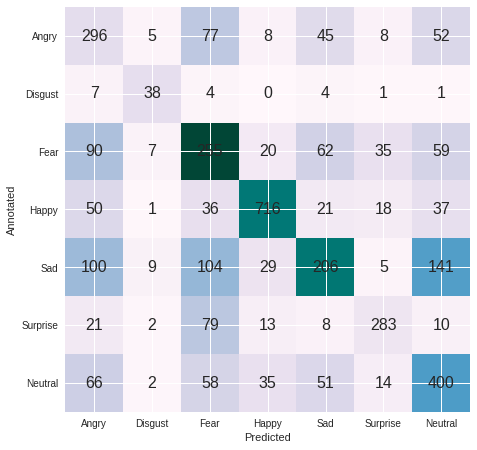

In [28]:
cm = confusion_matrix(te_labels, temp)
fig = plt.figure(figsize=(7,7))
f  = fig.add_subplot(111)
for i in range(0,7):
  for j in range(0,7):  
    f.text(i,j,cm[j,i],va='center', ha='center')
    
matplotlib.rcParams.update({'font.size': 18})
ticks = np.arange(len(tr_set_emotions_label))
f.set_xticks(ticks)
f.set_yticks(ticks)
f.set_xticklabels(tr_set_emotions_label)
f.set_yticklabels(tr_set_emotions_label)

plt.tight_layout()
plt.ylabel('Annotated')
plt.xlabel('Predicted')
plt.imshow(cm.astype('uint8'),cmap=plt.cm.PuBuGn)

# 7. Appendix

## Logs
* 30/6 : Final revision(DONE)
* 28/6 : Writing the tutorial(DONE)
* 27/6 : Implemented Cyclic learning rates with filter sixe of 7. Reached 61.5% in 50 epochs. Cyclic learing rate didn't have much affect.(DONE)
* 25/6 : Tried implementing Learning rate scheduler. No change in initial epochs(DONE)
* 23/6 : Tried few more parameters. Not much change observed except in increasing parameters(DONE)
* 21/6 : used kernel_size=5 with data augmentation and class weights. Amazing improvement in performance. Tuning Hyperparameters (DONE)
* 20/6 : Found few valuable observations during the hyperparameter tuning. (DONE)
* 19/6 : Experimenting with hyperparameters. (DONE)
* 18/6 : Ditching Winograd Implementation. Going with Seperable Conv. (DONE)
* 16/6 : Implementing winograd convolutions for 2D data (ABORTTED)
* 14/6 : Performing EDA and some data pre-processing. (DONE)
* 13/6 : Setting up Jupyter Notebook. (DONE)
* 12/6 : Understanding Winograg Convolution. (DONE)
* 10/6 : Starting literature survey. (DONE)

## References

* [zplure's architecture](https://github.com/zlpure/Facial-Expression-Recognition)
* [Keras documentation](https://keras.io/)
* [Cyclic Learning rates](https://arxiv.org/abs/1506.01186)

## Future Works

* Write the introduction to CNNs in much more detail.
* Added some more debugging stratagies with more detailed explanation.
* Use more augmented data.
* Initially, I have used 800,00 parameters. At that time, I was using the basic architecture. I observed that the model was overfitting heavily. Then I restricted my parameters to 200,000. After applying different filter sizes and cyclic learning rates and tuning hyper-parameters, I realised that I limited my parameters and focussed more on hyper-parameter tuning. Given more time, I would start from this point. I'm sure that the performance of the model would improve.

# Conclusion
The model has an test accuracy of 61.1%. The state of the art using a CNN is around 69.9%. Currently I stand position12 in the kaggle competition. I believe there is some room for improvement by using different architectures.